In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Solving
####  $\nabla^2 u(x,y) = 0$,
## For boundary condition
#### $u(0, y) = \sin(\pi y)$,
#### $u(1, y) = 0$,
#### $u(x, 0) = 0$,
#### $u(x, 1) = 0$.

## Solution
#### $u(x,y) = \sum_{n=0}^{\infty} A_n \sinh[(n+1)\pi (x-1)] \sin[(n+1)\pi y]$,
#### for
#### $A_n = -\frac{2}{ \sinh((n+1)\pi)} \int_0^1 \sin(\pi y)\sin((n+1)\pi y) dy =  -\frac{2 \sin(n \pi)}{n \pi(n+2)\sinh((n+1)\pi) } 
= \begin{cases} - \frac{1}{\sinh \pi } &, n=0 \\ 0 &, otherwise \end{cases}$
## So,
### $u(x,y) = - \frac{\sinh (\pi(x-1)) \sin(\pi y)}{\sinh \pi } $

[link](https://en.wikiversity.org/wiki/Partial_differential_equations/Laplace_Equation)

In [2]:
def exact_solution(x,y,sin=np.sin, sinh=np.sinh):
    return -sinh(np.pi*(x-1))*sin(np.pi*y)/np.sinh(np.pi)

In [41]:
def plot_surf(X,Y, sol, scatter=False, c='blue'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if scatter:
        ax.scatter(X,Y,sol, marker='.', color=c)
    else:
        ax.plot_surface(X,Y,sol)
    plt.title("solution"); plt.xlabel("X"); plt.ylabel("Y")    
    plt.show()

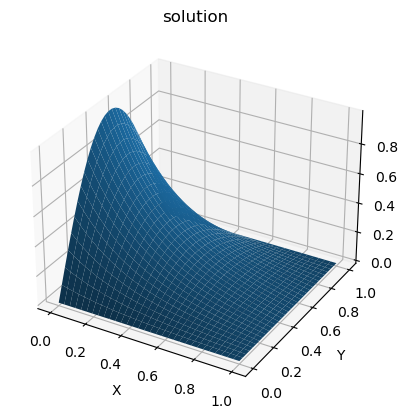

In [4]:
x = np.linspace(0, 1, 32)#[1:-1]
y = np.linspace(0, 1, 32)#[1:-1]
X,Y = np.meshgrid(x, y, indexing='ij')

sol = exact_solution(X, Y)

def plot_surf(X,Y, sol, scatter=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if scatter:
        ax.scatter(X,Y,sol, marker='.')
    else:
        ax.plot_surface(X,Y,sol)
    plt.title("solution"); plt.xlabel("X"); plt.ylabel("Y")    
    plt.show()
plot_surf(X,Y, sol)

In [5]:
from multiprocessing import Pool, shared_memory
from itertools import product

In [6]:
def proc(args):
    import torch
    import torch.nn as nn
    from pinns import Net_dense_normalised 
    device_id ,layers_index, layers, lr_index, lr, lambda_index, lambda_physics = args
    device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")
    
    def exact_solution(x,y,sin=torch.sin, sinh=torch.sinh):
        return -sinh(np.pi*(x-1))*sin(np.pi*y)/np.sinh(np.pi)

    x = torch.linspace(0, 1, 32).to(device)
    y = torch.linspace(0, 1, 32).to(device)
    X,Y = torch.meshgrid(x, y, indexing='ij')


    boundary_X_x = torch.hstack([x, 
                                 x,
                                 torch.ones_like(y)*x[0].item(), 
                                 torch.ones_like(y)*x[-1].item()])
    boundary_X_y = torch.hstack([torch.ones_like(x)*y[0].item(), 
                                 torch.ones_like(x)*y[-1].item(),
                                 y,
                                 y])
    boundary_X = torch.vstack([boundary_X_x, boundary_X_y]).T#.requires_grad_(True)
    def boundary_function(x):
        return torch.where( x[:, 0] == 0, 
                           torch.sin(np.pi*x[:, 1]), 
                           0)

    boundary_f = boundary_function(boundary_X).to(device)

    physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

    lb = torch.tensor([0., 0.]).to(device)
    ub = torch.tensor([1., 1.]).to(device)
    model = Net_dense_normalised(layers, lb, ub).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    epochs = 100000
    loss_boundary = 0.0
    lambda_boundary = 1.0
    loss_physics = 0.0
    

    actual_f = exact_solution(X, Y, sin=torch.sin, sinh=torch.sinh).flatten()
    losses = np.zeros((2, epochs))
    rmses = np.zeros( epochs)

    for i in range(epochs):
        optimizer.zero_grad()

        #################################
        # boundary loss
        boundary_f_hat = model(boundary_X).squeeze()
        loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

        #################################
        # physics derivatives
        physics_f = model(physics_X).squeeze()
        dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
        dx, dy = dxy[:,0], dxy[:,1]
        dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
        dx2 =  dxy2[:,0]
        dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
        dy2 =  dyx2[:,0]
        laplacian = dx2 + dy2
        ################################
        # physics loss
        # Construct the physics loss here
        loss_physics = torch.mean(laplacian**2)    

        total_loss = (
            +lambda_boundary*loss_boundary
            +lambda_physics*loss_physics
                        )

        total_loss.backward(retain_graph=True)
        optimizer.step()
        losses[:,i] = (loss_boundary.item(), loss_physics.item())
        f = model(physics_X).squeeze()
        rmses[i] = torch.sqrt(torch.mean((actual_f-f)**2)).item()
        
    torch.save(model.state_dict(), 
               f"./Laplace_eq_outputs/model_lr_{lr_index}_layers_{layers_index}_lambda_{lambda_index}.pt")
    np.save(f"./Laplace_eq_outputs/losses_lr_{lr_index}_layers_{layers_index}_lambda_{lambda_index}.npy", 
            losses)
    np.save(f"./Laplace_eq_outputs/rmses_lr_{lr_index}_layers_{layers_index}_lambda_{lambda_index}.npy", 
            rmses)    
    
lrs = [5e-5 ,1e-5]
lambdas = [1e-1, 5e-2, 1e-2, 1e-3]
layers = [[2, 32, 32, 1], [2, 64, 64, 1], 
          [2, 128, 128, 1], [2, 512, 512, 1]]

params = [ (ly_index, ly, lr_index, lr, la_index, la) 
    for ((ly_index, ly), (lr_index, lr), (la_index, la)) in product(enumerate(layers), enumerate(lrs), enumerate(lambdas))]


devices = ["0", "1", "2"]
params = [ (devices[i%3], ly_index, ly, lr_index, lr, la_index, la) 
         for i, (ly_index, ly, lr_index, lr, la_index, la) in enumerate(params) ]


with Pool(3*3) as pool:
    res = pool.map(proc, params)


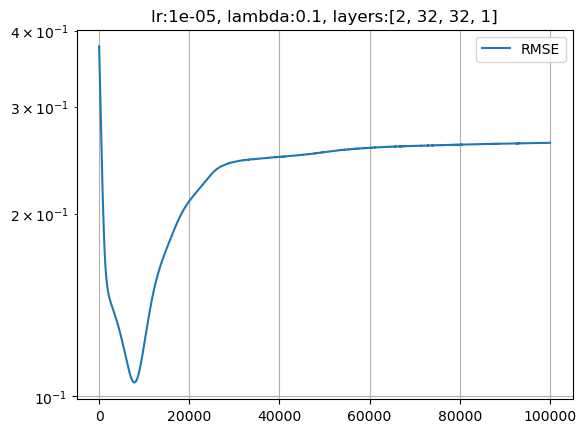

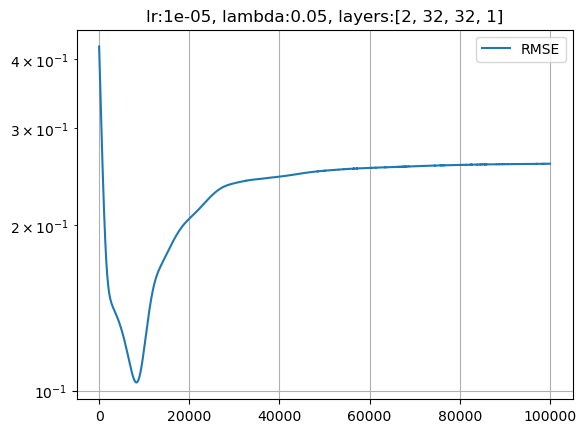

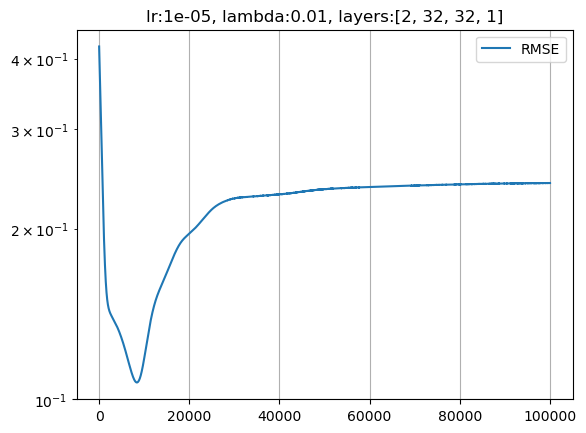

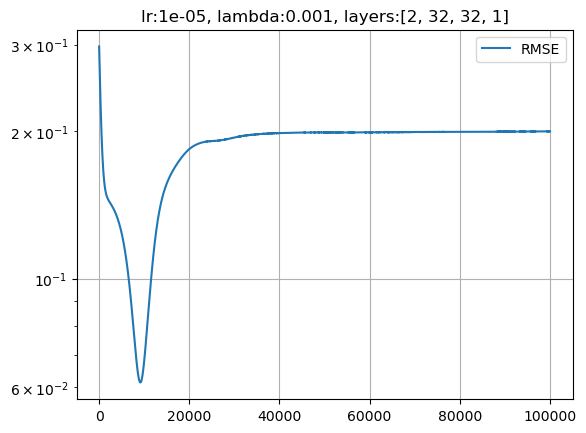

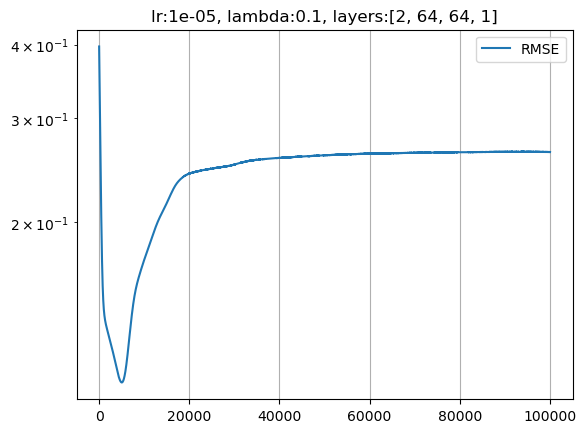

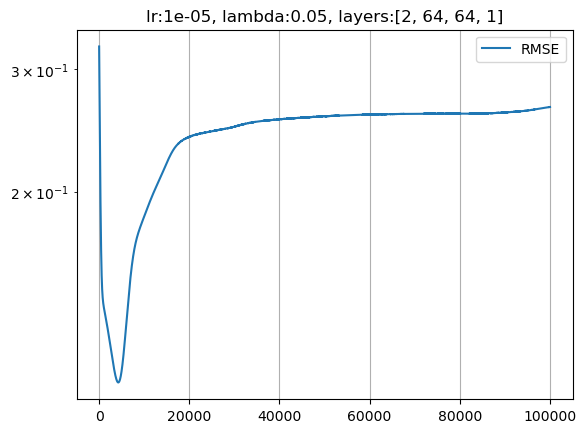

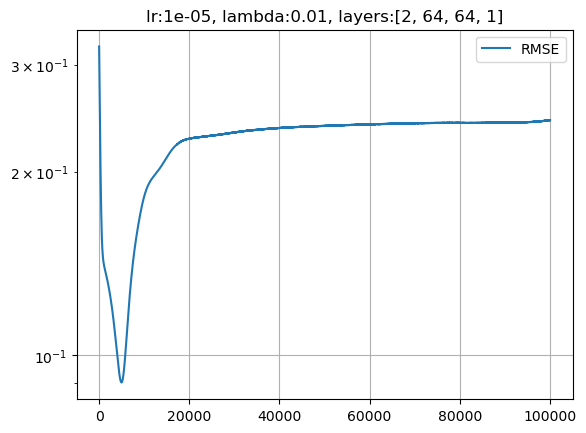

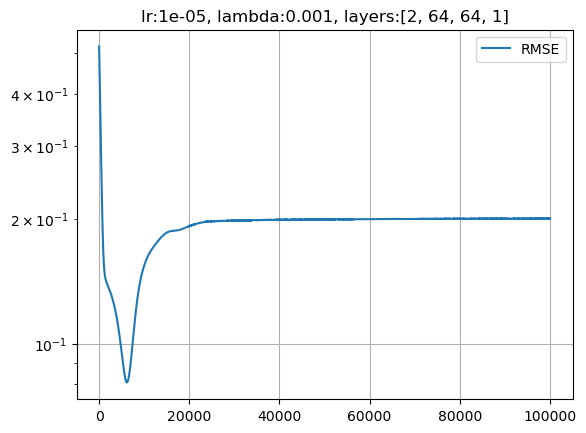

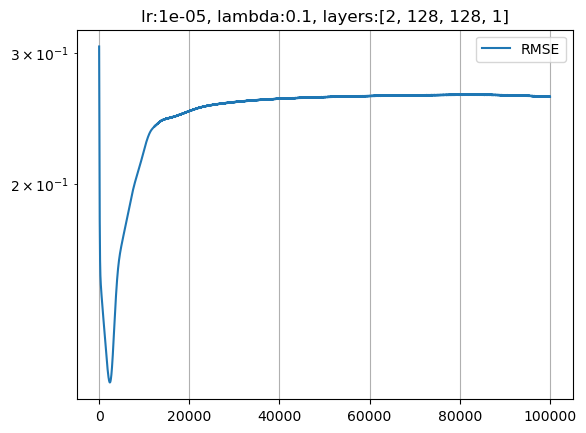

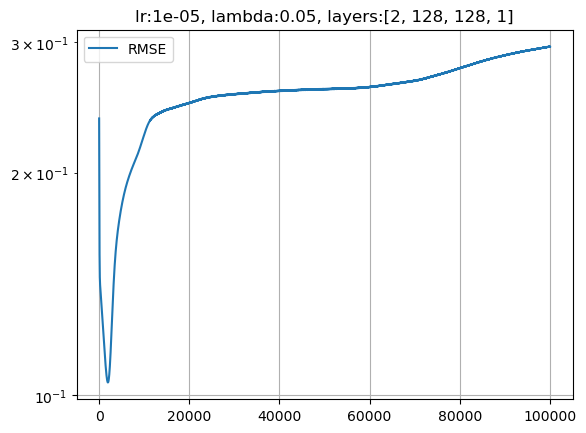

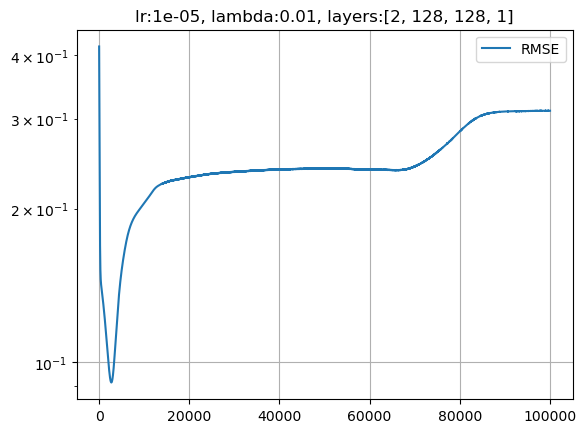

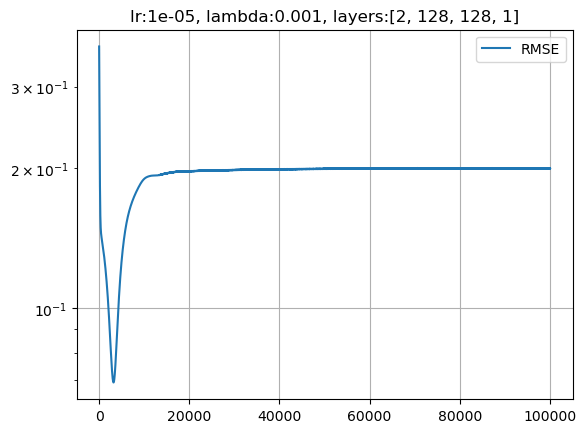

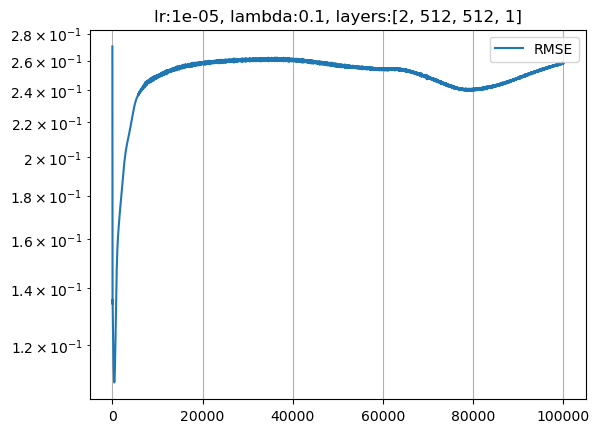

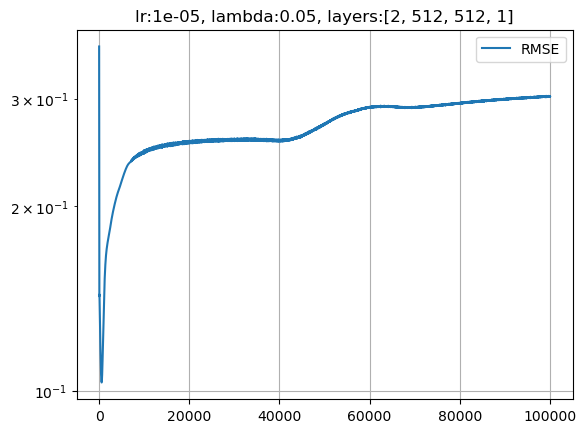

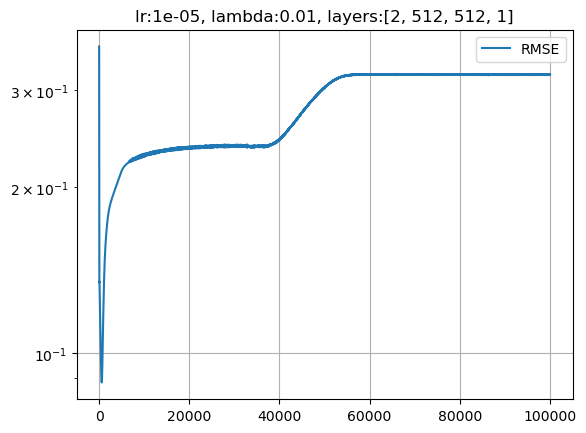

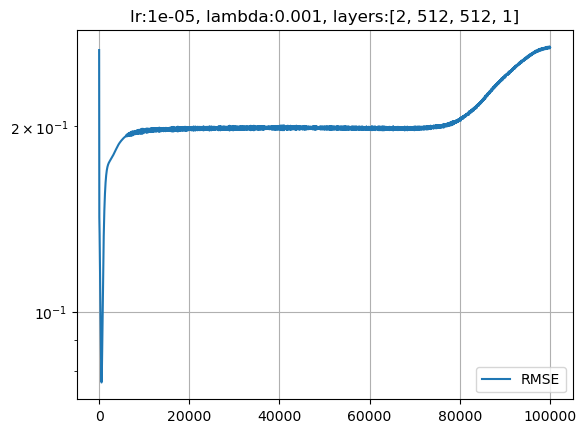

In [48]:
for r, (_,ly_index, ly, lr_index, lr, la_index, la) in zip(res, params):
    if lr != 1e-5:
        continue
    losses = np.load(f"./Laplace_eq_outputs/losses_lr_{lr_index}_layers_{ly_index}_lambda_{la_index}.npy")
#     plt.plot(losses[0,:], label="boundary")    
#     plt.plot(losses[1,:], label="physics")
#     plt.plot(np.sum(losses, axis=0), label="loss")
#     plt.title(f"lr:{lr}, lambda:{la}, layers:{ly}");plt.legend()
#     plt.yscale('log'); plt.show()
    rmses = np.load(f"./Laplace_eq_outputs/rmses_lr_{lr_index}_layers_{ly_index}_lambda_{la_index}.npy")
    plt.plot(rmses, label="RMSE")
    #plt.plot(np.sum(losses, axis=0), label="loss")
    plt.title(f"lr:{lr}, lambda:{la}, layers:{ly}");plt.legend();plt.grid()
    plt.yscale('log'); plt.show()
    

In [12]:
import torch
import torch.nn as nn
from pinns import Net_dense_normalised 
device = torch.device(f"cuda:2" if torch.cuda.is_available() else "cpu")

In [40]:
lr_index = 1
ly_index = 2#
la_index = 3

bn_state_dict = torch.load(f"./Laplace_eq_outputs/model_lr_{lr_index}_layers_{ly_index}_lambda_{la_index}.pt")
print(f"Layers: {layers[ly_index]}, lr:{lrs[lr_index]}, lambda:{lambdas[la_index]}")
lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([1., 1.]).to(device)    
model = Net_dense_normalised(layers[ly_index], lb, ub).to(device)
model.load_state_dict(bn_state_dict)

Layers: [2, 128, 128, 1], lr:1e-05, lambda:0.001


<All keys matched successfully>

In [36]:
x = torch.linspace(0, 1, 32).to(device)
y = torch.linspace(0, 1, 32).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')


boundary_X_x = torch.hstack([x, 
                             x,
                             torch.ones_like(y)*x[0].item(), 
                             torch.ones_like(y)*x[-1].item()])
boundary_X_y = torch.hstack([torch.ones_like(x)*y[0].item(), 
                             torch.ones_like(x)*y[-1].item(),
                             y,
                             y])
boundary_X = torch.vstack([boundary_X_x, boundary_X_y]).T#.requires_grad_(True)
def boundary_function(x):
    return torch.where( x[:, 0] == 0, 
                       torch.sin(np.pi*x[:, 1]), 
                       0)

boundary_f = boundary_function(boundary_X).to(device)

physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)


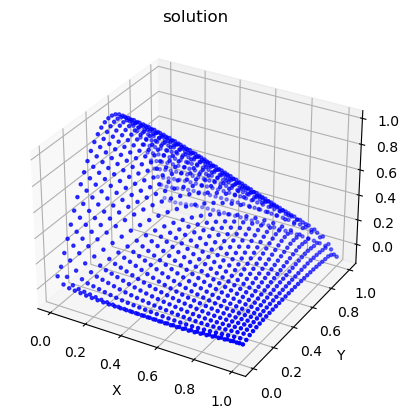

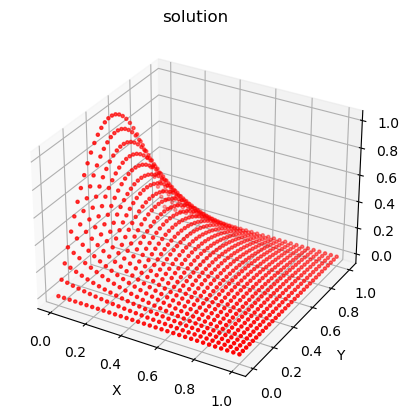

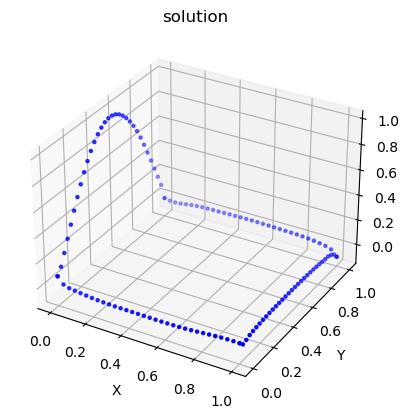

In [45]:
solution = model(physics_X).cpu().detach()
plot_surf(physics_X[:,0].cpu().detach(), 
          physics_X[:,1].cpu().detach(),
          solution,
          scatter=True)

plot_surf(physics_X[:,0].cpu().detach(), 
          physics_X[:,1].cpu().detach(),
          exact_solution(physics_X[:,0].cpu().detach(), physics_X[:,1].cpu().detach()),
          scatter=True,
          c='red')

boundary_solution = model(boundary_X).cpu().detach()
plot_surf(boundary_X[:,0].cpu().detach(), 
          boundary_X[:,1].cpu().detach(),
          boundary_solution,
          scatter=True)